## Answer/Execute the following statements:

### RFM and K-Means
1. Load the `new_df` from yesterday.
2. Make a new df `history_df` where you place the RFM per CustomerID.
3. For easier interpretation, convert the RFM values to log scale. (Hint: Use `.apply(math.log)`.
3. Plot the 3 of them vs Amount.
4. Create a 3D plot of RFM by running this (make sure to name your variables accordingly):

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import math
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import scipy
import copy

In [4]:
# 1 Load the new_df from yesterday.
df = pd.read_csv('H_new_df.csv', index_col=0)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:
df.shape

(397884, 9)

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
reference_date = max(df['InvoiceDate']) + timedelta(days=1)

In [9]:
# 2 Make a new df history_df where you place the RFM per CustomerID.
df['total_price'] = df['Quantity'] * df['UnitPrice']

### Creates RFM
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # turns InvoiceDate to datetime type

reference_date = max(df['InvoiceDate']) + timedelta(days=1) # latest purchase in the whole dataset

df_RFM = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days,
                                       'InvoiceNo': 'count',
                                       'total_price': 'sum'})
df_RFM.head()

,InvoiceDate,InvoiceNo,total_price
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [10]:
### Renames columns 
df_RFM = df_RFM.rename(columns={'InvoiceDate':'Recency',
                                'InvoiceNo':'Frequency',
                                'total_price':'Monetary'})

df_RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [11]:
### DONE 
# total quantity = Rai 
# total unique items = Danilo 
# day of the week = Franz
# time of day (4 classifications) = Elissa 

### TO DO 
# weekend flag (1 or 0
# uk vs non uk (flag 1 or 0)
# seasonality (quarterly), get quarters
# products a customer buys -> product classification (luxury items, most bought items, )
# activity based on frequency 
# activity based on monetary
# discounted prices 
# bulk buying -> buy more, lower price

In [12]:
df_RFM['Recency_Activity'] = pd.qcut(df_RFM['Recency'], 4, labels=[4, 3, 2, 1])

In [13]:
df_RFM['TotalQuantity'] = df.groupby('CustomerID')['Quantity'].sum()

In [14]:
df_RFM['UniqueItems'] = df.groupby('CustomerID')['StockCode'].nunique()

In [15]:
df['InvoiceDate'].apply(lambda x: x.hour).unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  7, 18, 19, 20,  6],
      dtype=int64)

In [16]:
# df['Time'] = df['InvoiceDate'].apply(lambda x: 'Morning' if x.hour >= 6 and x.hour < 12 else 
#                                                'Afternoon')

df['Time'] = df['InvoiceDate'].apply(lambda x: '6-12 Morning' if x.hour >= 6 and x.hour < 12 else (
                                               '12-18 Afternoon' if x.hour >= 12 and x.hour < 18 else
                                               '18-20 Night'))

In [17]:
for i in df['Time'].unique():
    df[f'{i}_flag'] = df['Time'].apply(lambda x: 1 if x == i else 0)
    df_RFM[f'Num_{i}'] = df.groupby('CustomerID')[f'{i}_flag'].sum()
    df_RFM[f'Percent_{i}'] = df_RFM[f'Num_{i}'] / df_RFM['Frequency'] # * 100

In [18]:
df['UKppl'] = df['Country'] == 'United Kingdom'
df_RFM['Country_UK'] = df.groupby('CustomerID')['UKppl'].unique()
df_RFM['Country_UK'] = df_RFM['Country_UK'].apply(lambda x: 1 if x == True else 0)

In [19]:
df_RFM['Time'] = df.groupby('CustomerID')['Time'].unique()

In [20]:
df['Weekday'] = df['InvoiceDate'].dt.day_name()

In [21]:
df['Weekend'] = df['Weekday'].apply(lambda x: 1 if (x=='Sunday') | (x=='Saturday') else 0)
df.groupby('CustomerID').agg({'Weekend': 'sum'})
df_RFM['Num_weekend'] = df.groupby('CustomerID').agg({'Weekend': 'sum'})
df_RFM['Percent_weekend'] = df_RFM['Num_weekend'] / df_RFM['Frequency'] # * 100

In [22]:
df_RFM['Days'] = df.groupby('CustomerID')['Weekday'].unique()

In [23]:
df_RFM['Frequency_Activity'] = pd.qcut(df_RFM['Frequency'], 4, labels=[4, 3, 2, 1])

In [24]:
# df['Quarter'] = df['InvoiceDate'].dt.quarter
# df_RFM['Quarter'] = df.groupby('CustomerID')['Quarter'].unique()
df['Season'] = df['InvoiceDate'].apply(lambda x: 'Winter' if x.month in [12, 1, 2] else (
                                                 'Spring' if x.month in [3, 4, 5] else (
                                                 'Summer' if x.month in [6, 7, 8] else
                                                 'Autumn')))
df_RFM['Season'] = df.groupby('CustomerID')['Season'].unique()

In [25]:
# for i in df['Quarter'].unique():
#     df[f'{i}q_flag'] = df['Quarter'].apply(lambda x: 1 if x == i else 0)
#     df_RFM[f'Num_{i}q'] = df.groupby('CustomerID')[f'{i}q_flag'].sum()
#     df_RFM[f'Percent_{i}q'] = df_RFM[f'Num_{i}q'] / df_RFM['Frequency'] # * 100

for i in df['Season'].unique():
    df[f'{i}_flag'] = df['Season'].apply(lambda x: 1 if x == i else 0)
    df_RFM[f'Num_{i}'] = df.groupby('CustomerID')[f'{i}_flag'].sum()
    df_RFM[f'Percent_{i}'] = df_RFM[f'Num_{i}'] / df_RFM['Frequency'] # * 100

In [26]:
df_RFM['Monetary_Activity'] = pd.qcut(df_RFM['Monetary'], 4, labels=[1, 2, 3, 4])

In [27]:
# Columns included
perc_col = [col for col in df_RFM.columns if 'Percent' in col]
included = ['Recency', 'Frequency', 'Monetary', 'Recency_Activity', 'Frequency_Activity', 'Monetary_Activity', 
            'TotalQuantity', 'UniqueItems'] + perc_col

In [28]:
df_RFM.columns

Index(['Recency', 'Frequency', 'Monetary', 'Recency_Activity', 'TotalQuantity',
       'UniqueItems', 'Num_6-12 Morning', 'Percent_6-12 Morning',
       'Num_12-18 Afternoon', 'Percent_12-18 Afternoon', 'Num_18-20 Night',
       'Percent_18-20 Night', 'Country_UK', 'Time', 'Num_weekend',
       'Percent_weekend', 'Days', 'Frequency_Activity', 'Season', 'Num_Winter',
       'Percent_Winter', 'Num_Spring', 'Percent_Spring', 'Num_Summer',
       'Percent_Summer', 'Num_Autumn', 'Percent_Autumn', 'Monetary_Activity'],
      dtype='object')

In [29]:
included.remove('Percent_18-20 Night')
included.remove('Percent_Winter')
# included.remove('Percent_4q')
# included.remove('Percent_Afternoon')

In [30]:
included

['Recency',
 'Frequency',
 'Monetary',
 'Recency_Activity',
 'Frequency_Activity',
 'Monetary_Activity',
 'TotalQuantity',
 'UniqueItems',
 'Percent_6-12 Morning',
 'Percent_12-18 Afternoon',
 'Percent_weekend',
 'Percent_Spring',
 'Percent_Summer',
 'Percent_Autumn']

In [31]:
corr = df_RFM[included].corr()

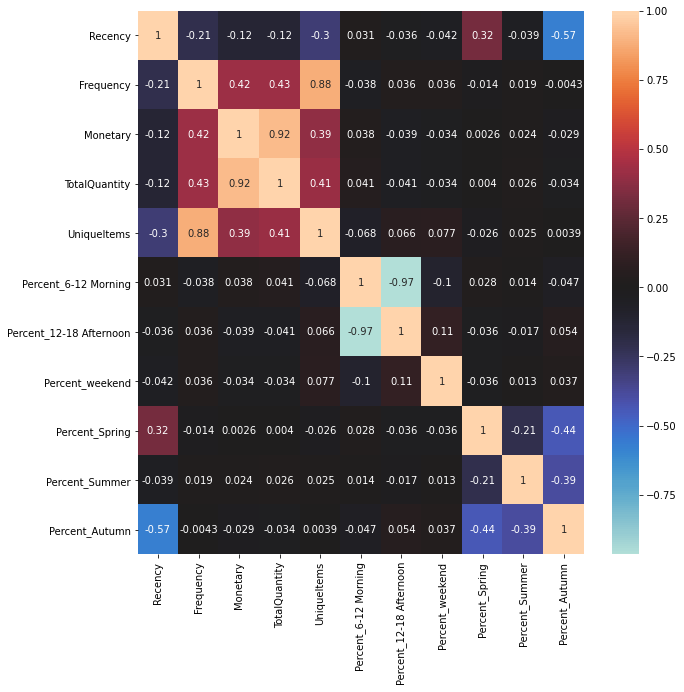

In [32]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, center=0)

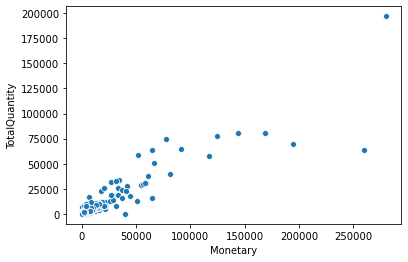

In [40]:
sns.scatterplot(y = df_RFM_cp['TotalQuantity'], x = df_RFM_cp['Monetary'], palette = 'rocket')

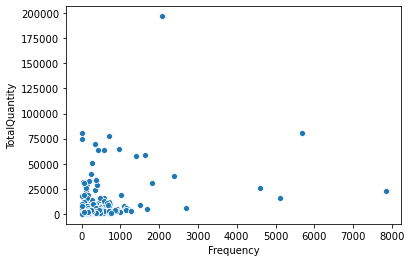

In [42]:
sns.scatterplot(y = df_RFM_cp['TotalQuantity'], x = df_RFM_cp['Frequency'], palette = 'rocket')
# sns.title

In [36]:
df_RFM_cp = df_RFM.copy(deep=True)

<font color=red>**Note:**</font> Comment out to disregard log transformation

In [ ]:
df_RFM[included].dtypes

In [37]:
# 3 For easier interpretation, convert the RFM values to log scale. (Hint: Use .apply(math.log)
for col in included: 
    if col in ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'UniqueItems']:
        df_RFM[col] = df_RFM[col].apply(math.log)
    else:
        continue

# df_RFM['Recency_log'] = df_RFM['Recency'].apply(math.log)
# df_RFM['Frequency_log'] = df_RFM['Frequency'].apply(math.log)
# df_RFM['Monetary_log'] = df_RFM['Monetary'].apply(math.log)
# df_RFM['Recency_Activity_log'] = df_RFM['Recency_Activity'].apply(math.log)
# df_RFM['Frequency_Activity_log'] = df_RFM['Frequency_Activity'].apply(math.log)
# df_RFM['Monetary_Activity_log'] = df_RFM['Monetary_Activity'].apply(math.log)
# df_RFM['TotalQuantity_log'] = df_RFM['TotalQuantity'].apply(math.log)
# df_RFM['UniqueItems_log'] = df_RFM['UniqueItems'].apply(math.log)

In [39]:
df_RFM

,Recency,Frequency,Monetary,Recency_Activity,TotalQuantity,UniqueItems,Num_6-12 Morning,Percent_6-12 Morning,Num_12-18 Afternoon,Percent_12-18 Afternoon,...,Season,Num_Winter,Percent_Winter,Num_Spring,Percent_Spring,Num_Summer,Percent_Summer,Num_Autumn,Percent_Autumn,Monetary_Activity
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,5.786897,0.000000,11.253942,1,11.214722,0.000000,1,1.000000,0,0.000000,...,[Winter],1,1.000000,0,0.000000,0,0.000000,0,0.000000,4
12347,0.693147,5.204007,8.368693,4,7.807103,4.634729,46,0.252747,136,0.747253,...,"[Winter, Spring, Summer, Autumn]",71,0.390110,24,0.131868,40,0.219780,47,0.258242,4
12348,4.317488,3.433987,7.494007,2,7.758333,3.091042,11,0.354839,3,0.096774,...,"[Winter, Spring, Autumn]",23,0.741935,5,0.161290,0,0.000000,3,0.096774,4
12349,2.944439,4.290459,7.471676,3,6.447306,4.290459,73,1.000000,0,0.000000,...,[Autumn],0,0.000000,0,0.000000,0,0.000000,73,1.000000,4
12350,5.736572,2.833213,5.812338,1,5.283204,2.833213,0,0.000000,17,1.000000,...,[Winter],17,1.000000,0,0.000000,0,0.000000,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,5.627621,2.302585,5.196285,1,3.806662,2.302585,10,1.000000,0,0.000000,...,[Spring],0,0.000000,10,1.000000,0,0.000000,0,0.000000,1
18281,5.198497,1.945910,4.392224,1,3.988984,1.945910,7,1.000000,0,0.000000,...,[Summer],0,0.000000,0,0.000000,7,1.000000,0,0.000000,1
18282,2.079442,2.484907,5.182064,4,4.634729,2.484907,5,0.416667,7,0.583333,...,"[Summer, Winter]",5,0.416667,0,0.000000,7,0.583333,0,0.000000,1


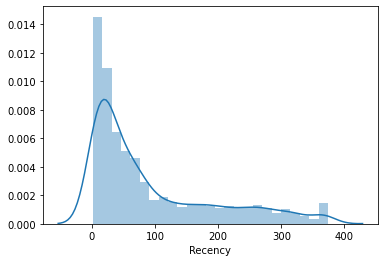

In [43]:
sns.distplot(df_RFM_cp['Recency'])

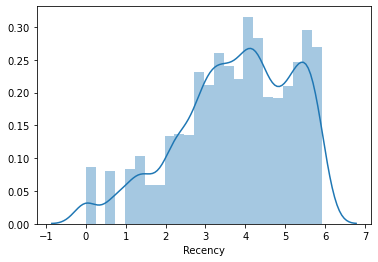

In [44]:
sns.distplot(df_RFM['Recency'])

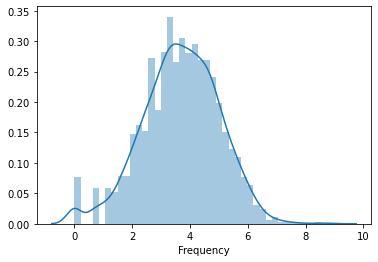

In [50]:
sns.distplot(df_RFM['Frequency'])

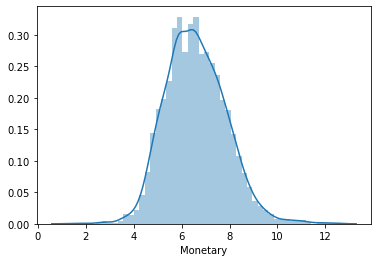

In [52]:
sns.distplot(df_RFM['Monetary'])

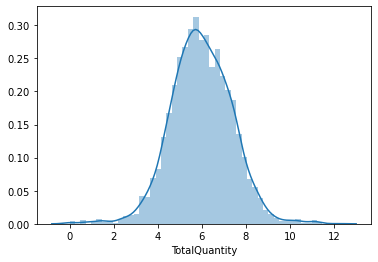

In [54]:
sns.distplot(df_RFM['TotalQuantity'])

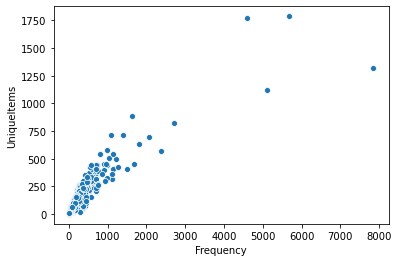

In [60]:
#4 Plot the 3 of them vs Amount.
sns.scatterplot(y=df_RFM_cp['UniqueItems'], x=df_RFM_cp['Frequency'])

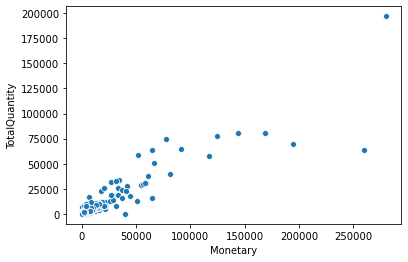

In [61]:
#4 Plot the 3 of them vs Amount.
sns.scatterplot(y=df_RFM_cp['TotalQuantity'], x=df_RFM_cp['Monetary'])

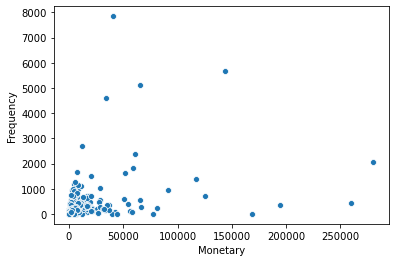

In [58]:
#4 Plot the 3 of them vs Amount.
sns.scatterplot(y=df_RFM_cp['Frequency'], x=df_RFM_cp['Monetary'])

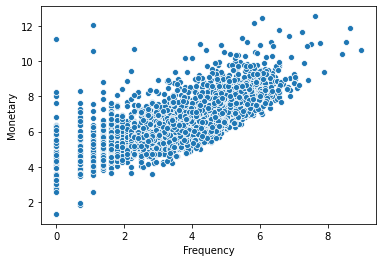

In [33]:
sns.scatterplot(y=df_RFM['Monetary'], x=df_RFM['Frequency'])

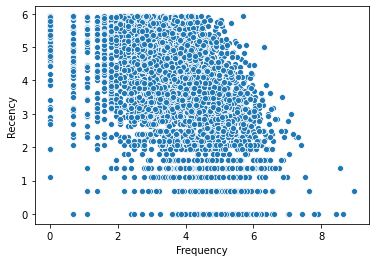

In [34]:
sns.scatterplot(y=df_RFM['Recency'], x=df_RFM['Frequency'])

In [35]:
df_RFM[included].corr()

# Recency_log
# Frequency_log
# Monetary_log
# Recency_Activity_log
# Frequency_Activity_log
# Monetary_Activity_log
# TotalQuantity_log
# UniqueItems_log

,Recency,Frequency,Monetary,TotalQuantity,UniqueItems,Percent_6-12 Morning,Percent_12-18 Afternoon,Percent_weekend,Percent_Spring,Percent_Summer,Percent_Autumn
Recency,1.000000,-0.485553,-0.484054,-0.481262,-0.432665,0.021938,-0.025446,-0.017435,0.282584,0.080368,-0.372474
Frequency,-0.485553,1.000000,0.756749,0.756300,0.981718,-0.078223,0.075922,0.105374,-0.045918,0.035029,0.033041
Monetary,-0.484054,0.756749,1.000000,0.918868,0.685276,0.051344,-0.046977,-0.026929,-0.003027,0.066059,-0.033552
TotalQuantity,-0.481262,0.756300,0.918868,1.000000,0.698103,0.039755,-0.036188,-0.020935,-0.032294,0.073460,0.005153
UniqueItems,-0.432665,0.981718,0.685276,0.698103,1.000000,-0.086008,0.084012,0.110839,-0.048183,0.022297,0.049883
Percent_6-12 Morning,0.021938,-0.078223,0.051344,0.039755,-0.086008,1.000000,-0.965310,-0.102415,0.028305,0.014496,-0.046563
Percent_12-18 Afternoon,-0.025446,0.075922,-0.046977,-0.036188,0.084012,-0.965310,1.000000,0.112437,-0.035620,-0.017209,0.053845
Percent_weekend,-0.017435,0.105374,-0.026929,-0.020935,0.110839,-0.102415,0.112437,1.000000,-0.036277,0.013190,0.037325
Percent_Spring,0.282584,-0.045918,-0.003027,-0.032294,-0.048183,0.028305,-0.035620,-0.036277,1.000000,-0.208827,-0.441776
Percent_Summer,0.080368,0.035029,0.066059,0.073460,0.022297,0.014496,-0.017209,0.013190,-0.208827,1.000000,-0.388292


In [ ]:
# 5 Create a 3D plot of RFM by running this (make sure to name your variables accordingly):

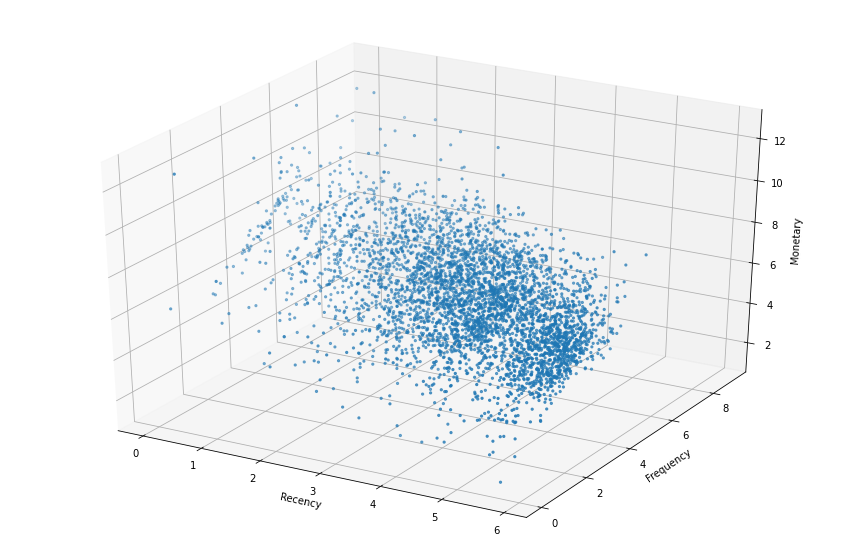

In [36]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

r = df_RFM.Recency
f = df_RFM.Frequency
m = df_RFM.Monetary
ax.scatter(r, f, m, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

6. Write down your observations.
7. Prepare the data for clustering by running this (make sure to name your variables accordingly):

In [ ]:
# 6 weak corr between freq and amt; rece and amt (nega corr)
# some sort of clustering around the right side of the graph

In [ ]:
# 7 Prepare the data for clustering by running this (make sure to name your variables accordingly):

In [39]:
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# feature_vector = ['Recency','Frequency', 'Monetary']
feature_vector = included
X_subset = df_RFM[feature_vector]
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

In [ ]:
# Franz + Danilo -> log transformation, find best k using ANOVA + tukey's test, find patterns in each clusters, 
#                   play around with features if clusters dont make sense

# Rai + Jonas -> without log transformation, find best k using ANOVA + tukey's test, find patterns in each clusters, 
#                   play around with features if clusters dont make sense

In [41]:
df_RFM_cp

,Recency,Frequency,Monetary,Recency_Activity,TotalQuantity,UniqueItems,Num_6-12 Morning,Percent_6-12 Morning,Num_12-18 Afternoon,Percent_12-18 Afternoon,...,Season,Num_Winter,Percent_Winter,Num_Spring,Percent_Spring,Num_Summer,Percent_Summer,Num_Autumn,Percent_Autumn,Monetary_Activity
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,326,1,77183.60,1,74215,1,1,1.000000,0,0.000000,...,[Winter],1,1.000000,0,0.000000,0,0.000000,0,0.000000,4
12347,2,182,4310.00,4,2458,103,46,0.252747,136,0.747253,...,"[Winter, Spring, Summer, Autumn]",71,0.390110,24,0.131868,40,0.219780,47,0.258242,4
12348,75,31,1797.24,2,2341,22,11,0.354839,3,0.096774,...,"[Winter, Spring, Autumn]",23,0.741935,5,0.161290,0,0.000000,3,0.096774,4
12349,19,73,1757.55,3,631,73,73,1.000000,0,0.000000,...,[Autumn],0,0.000000,0,0.000000,0,0.000000,73,1.000000,4
12350,310,17,334.40,1,197,17,0,0.000000,17,1.000000,...,[Winter],17,1.000000,0,0.000000,0,0.000000,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,45,10,10,1.000000,0,0.000000,...,[Spring],0,0.000000,10,1.000000,0,0.000000,0,0.000000,1
18281,181,7,80.82,1,54,7,7,1.000000,0,0.000000,...,[Summer],0,0.000000,0,0.000000,7,1.000000,0,0.000000,1
18282,8,12,178.05,4,103,12,5,0.416667,7,0.583333,...,"[Summer, Winter]",5,0.416667,0,0.000000,7,0.583333,0,0.000000,1


In [42]:
X_scaled

array([[ 1.40989446, -2.77515957,  3.69871931, ..., -0.67419948,
        -0.65972549, -1.02244302],
       [-2.14649825,  1.1495495 ,  1.410201  , ..., -0.24572685,
         0.1032208 , -0.34789324],
       [ 0.38397128, -0.18534723,  0.71641884, ..., -0.15012677,
        -0.65972549, -0.76966047],
       ...,
       [-1.17860486, -0.90111592, -1.11736527, ..., -0.67419948,
         1.36526111, -1.02244302],
       [-1.66255156,  2.22351465,  0.83796882, ..., -0.2444044 ,
         0.11169798,  0.03483005],
       [-0.00442205,  0.42893082,  0.73389579, ...,  0.67191871,
        -0.65972549,  0.5074933 ]])

8. Try out 2 <= k <= 20. 
9. Validate what the best k with elbow method, silhouette score, and Davies-Bouldin index.
10. Write down your observations.
11. If it is hard to decide for the best number of k, undo the log scaling and try clustering again.
12. Determine what makes sense in the clustering, and decide what the best k is.
13. To help you further, create a boxplot of clusters for each k for every RFM measure. The less the variance (or thickness of boxplot) the better.
14. Also, explore on adding other freatures per customer such as Country, how long the customer has been a customer, etc.

In [ ]:
# 8 Try out 2 <= k <= 10.

In [43]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [44]:
sse,db,slc = {}, {}, {}
for k in range(2, 10):
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10).fit(X_scaled) #random_state impt to reproduce results
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    db[k] = davies_bouldin_score(X_scaled,clusters)
    slc[k] = silhouette_score(X_scaled,clusters)

### Elbow Method

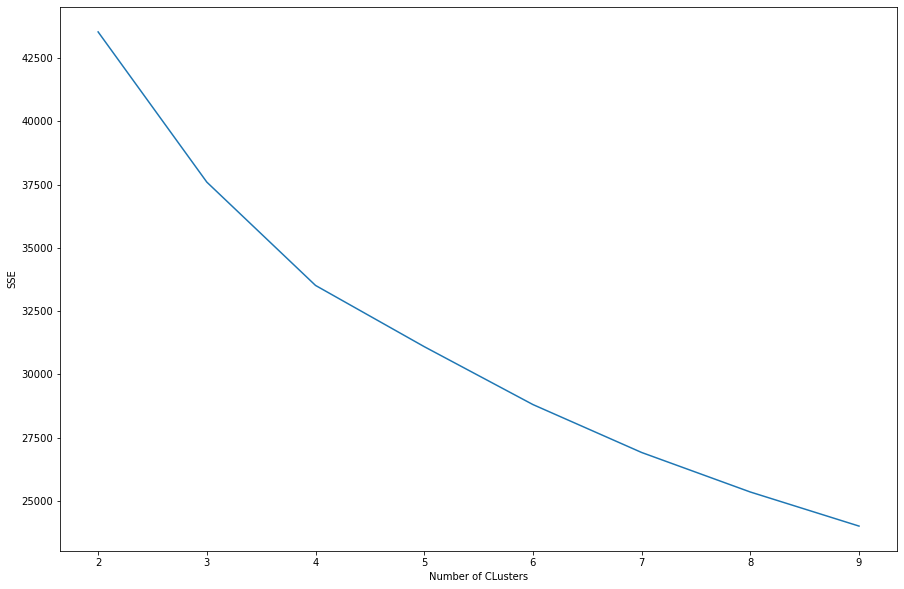

In [45]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of CLusters')
plt.ylabel('SSE')
plt.show()

In [46]:
from kneed import *
k1 = KneeLocator(range(2,10), list(sse.values()), curve='convex', direction='decreasing')
k1.elbow

4

### Davies Bouldin

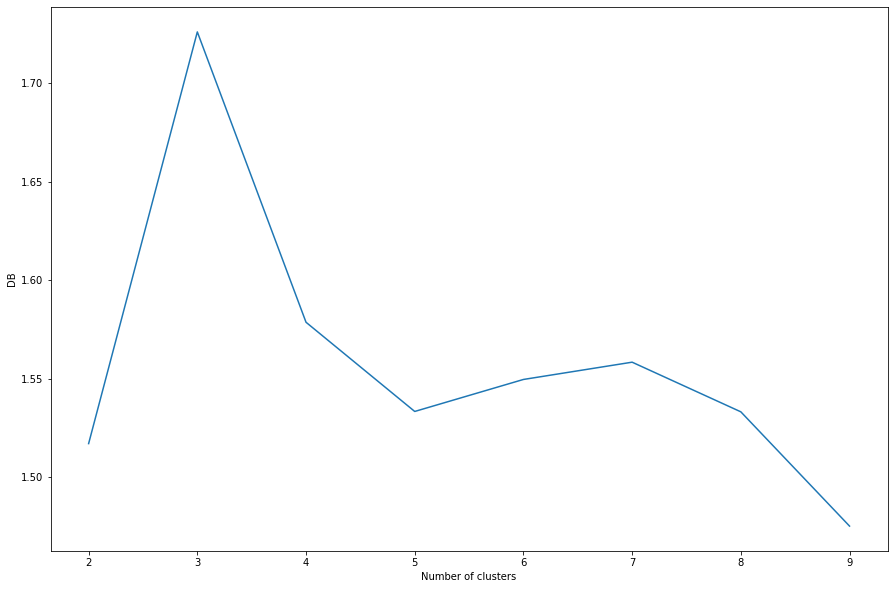

In [47]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel('Number of clusters')
plt.ylabel('DB')
plt.show()

In [48]:
#Minimum value means it is the best cluster
print(list(db.keys())[list(db.values()).index(min(db.values()))])

9


### Silhouette Analysis

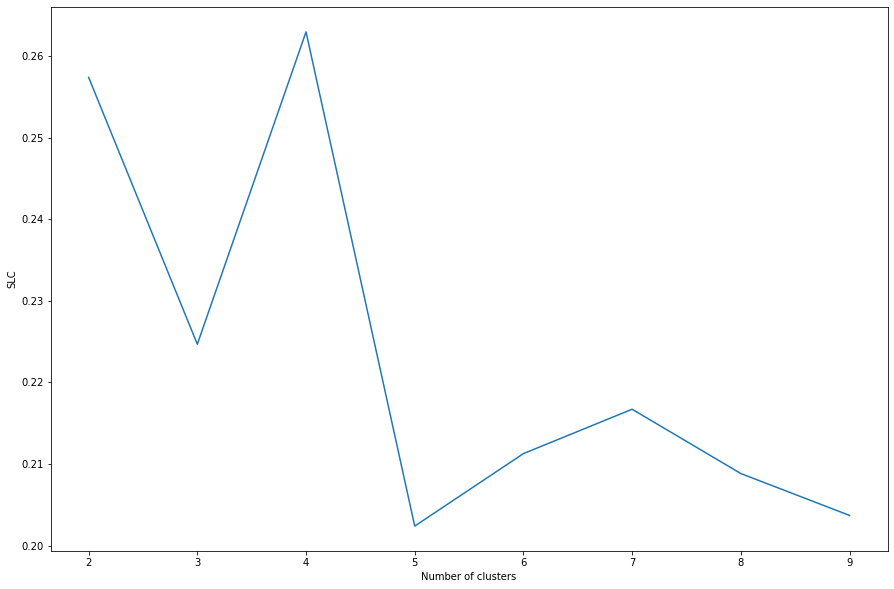

In [46]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SLC')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.25741994306427507
For n_clusters = 3 The average silhouette_score is : 0.22468971014324704
For n_clusters = 4 The average silhouette_score is : 0.2629939747142085
For n_clusters = 5 The average silhouette_score is : 0.2023854910454792
For n_clusters = 6 The average silhouette_score is : 0.21127665763381379
For n_clusters = 7 The average silhouette_score is : 0.21671713249096203
For n_clusters = 8 The average silhouette_score is : 0.20882971234053263
For n_clusters = 9 The average silhouette_score is : 0.20369454495391195


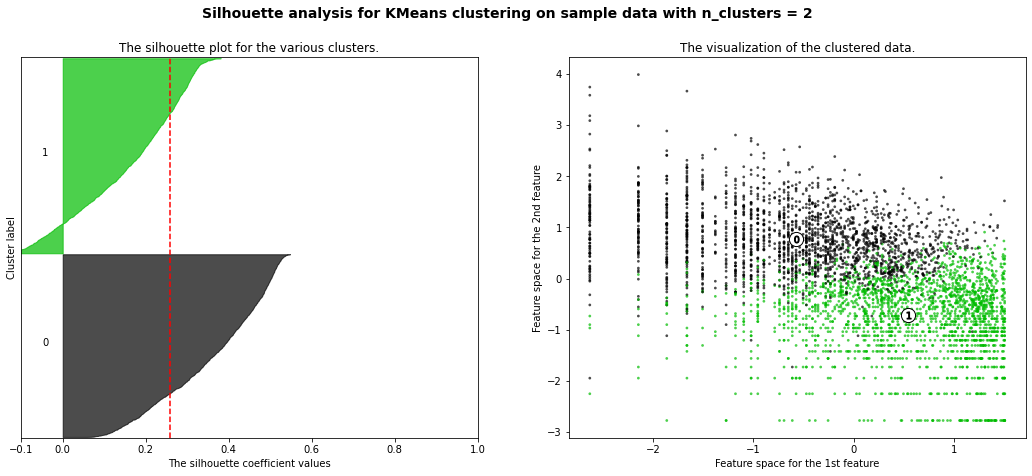

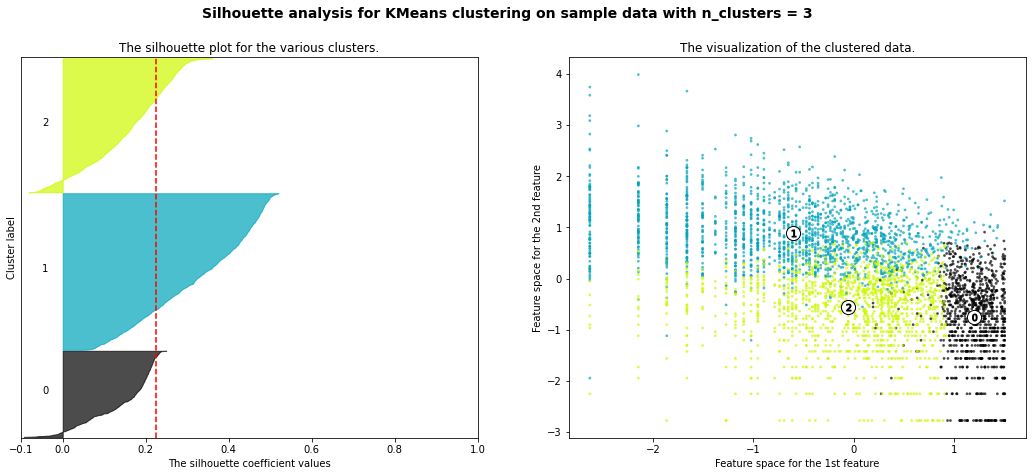

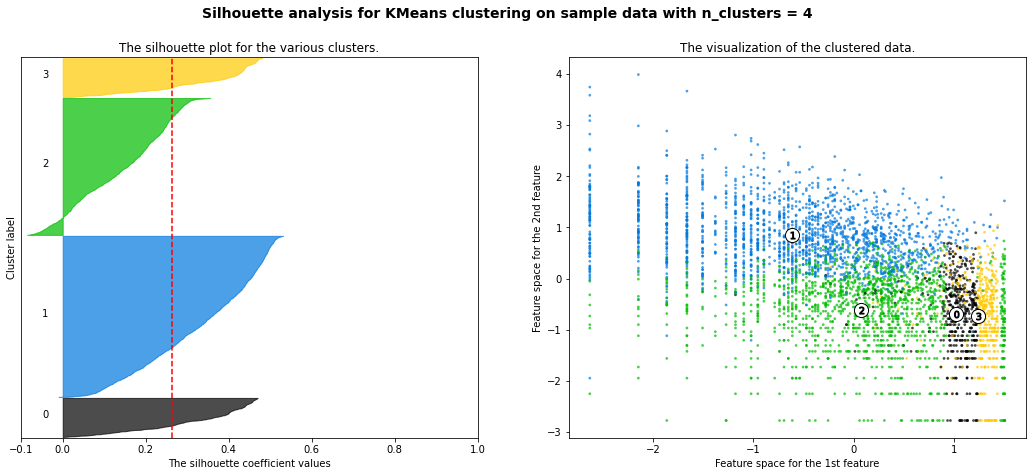

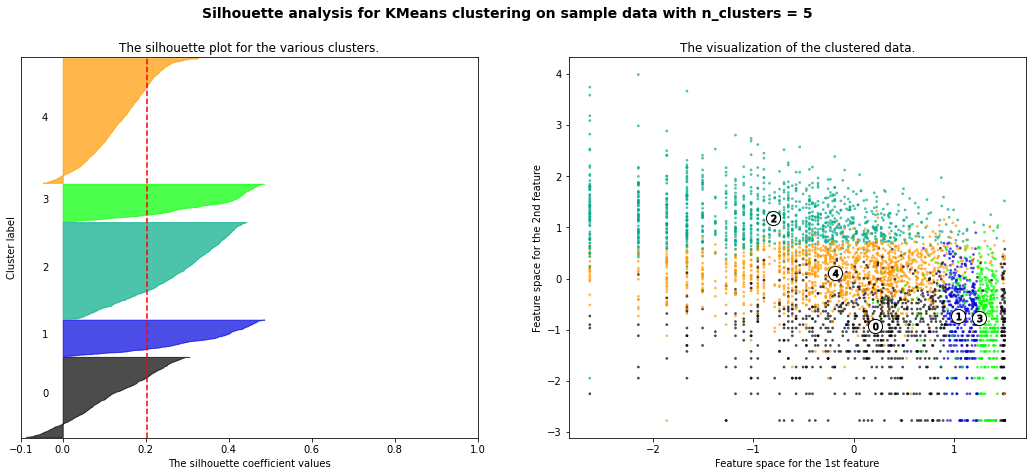

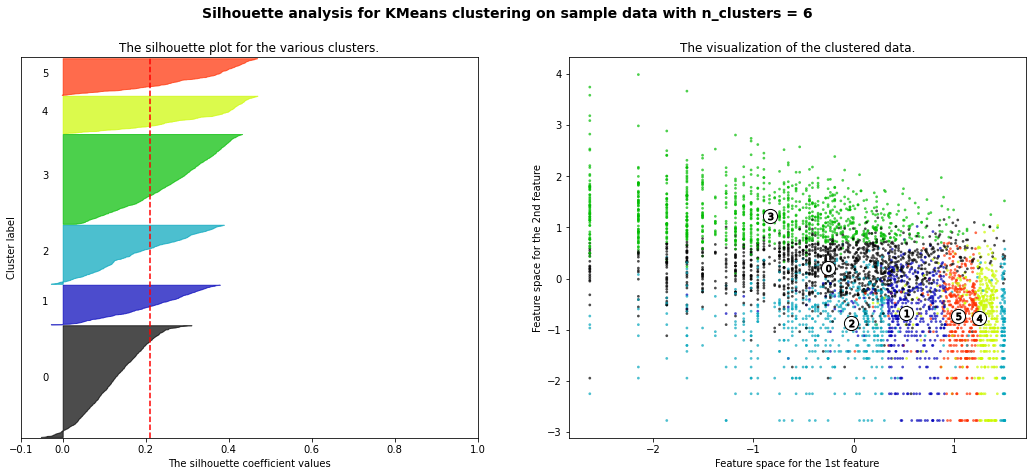

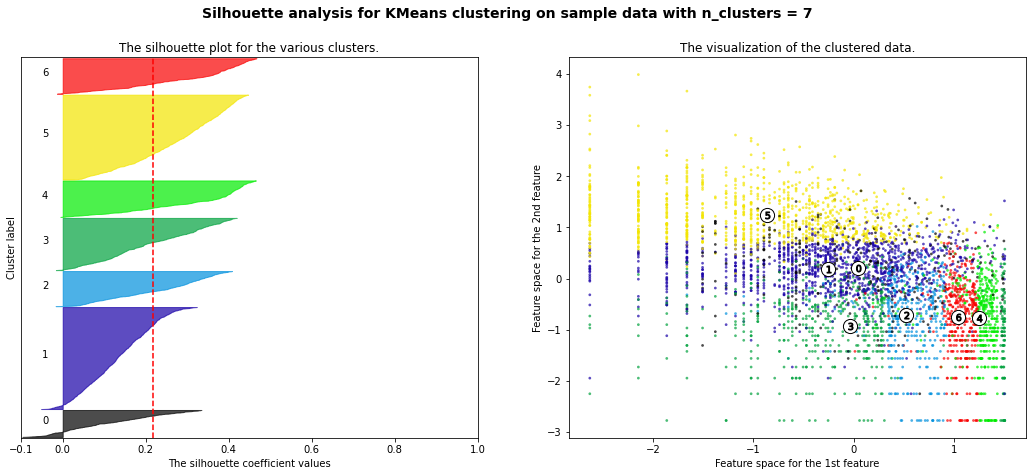

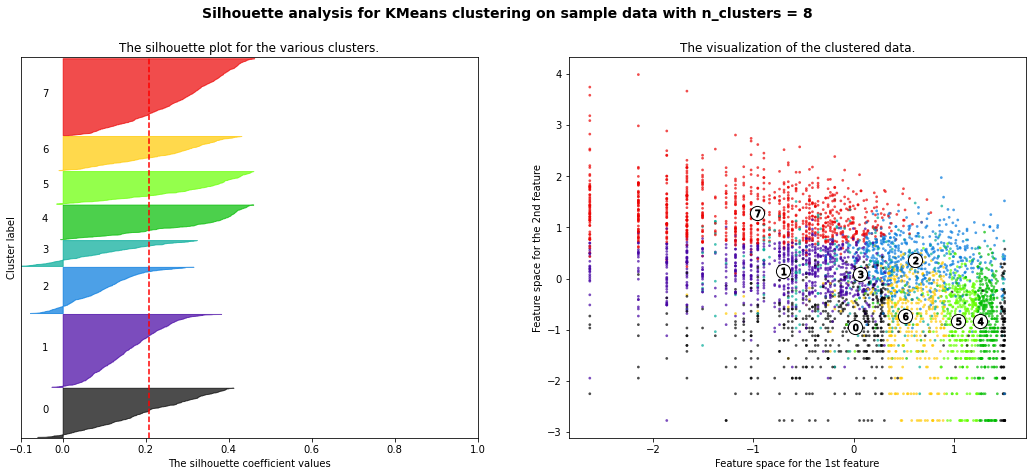

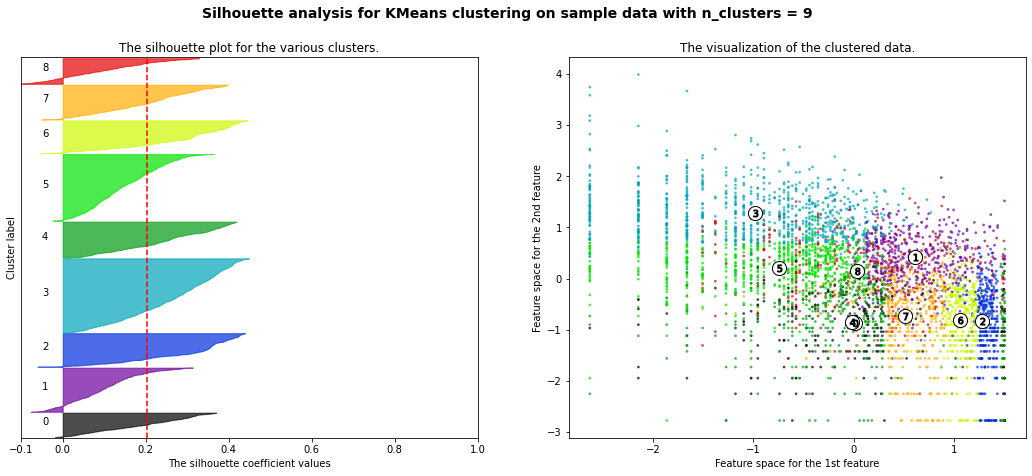

In [47]:
for n_clusters in range(2, 10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [54]:
df_RFM[included_log]

,Recency,Frequency,Monetary,Recency_Activity,Frequency_Activity,Monetary_Activity,TotalQuantity,UniqueItems,Percent_Morning,Percent_weekend,Percent_1q,Percent_2q,Percent_3q
CustomerID,,,,,,,,,,,,,
12346,5.786897,0.000000,11.253942,0.000000,1.386294,1.386294,11.214722,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
12347,0.693147,5.204007,8.368693,1.386294,0.000000,1.386294,7.807103,4.634729,0.252747,0.000000,0.159341,0.230769,0.120879
12348,4.317488,3.433987,7.494007,0.693147,1.098612,1.386294,7.758333,3.091042,0.354839,0.096774,0.193548,0.161290,0.096774
12349,2.944439,4.290459,7.471676,1.098612,0.693147,1.386294,6.447306,4.290459,1.000000,0.000000,0.000000,0.000000,0.000000
12350,5.736572,2.833213,5.812338,0.000000,1.386294,0.693147,5.283204,2.833213,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,5.627621,2.302585,5.196285,0.000000,1.386294,0.000000,3.806662,2.302585,1.000000,0.000000,1.000000,0.000000,0.000000
18281,5.198497,1.945910,4.392224,0.000000,1.386294,0.000000,3.988984,1.945910,1.000000,1.000000,0.000000,1.000000,0.000000
18282,2.079442,2.484907,5.182064,1.386294,1.386294,0.000000,4.634729,2.484907,0.416667,0.000000,0.000000,0.000000,0.583333


In [ ]:
# 9 elbow and davies have different outputs (elbow = 7, davies = 2, silhouette = 2)

In [ ]:
# 10 Write down your observations.
# 11 If it is hard to decide for the best number of k, undo the log scaling and try clustering again.
# 12 Determine what makes sense in the clustering, and decide what the best k is.
# 13 To help you further, create a boxplot of clusters for each k for every RFM measure. The less the variance (or thickness of boxplot) the better.

In [49]:
# 13
kmeans5 = KMeans(n_clusters=5, max_iter=1000,random_state=10).fit(X_scaled)

In [50]:
kmeans4 = KMeans(n_clusters=4, max_iter=1000,random_state=10).fit(X_scaled)

In [55]:
df_RFM['k5'] = kmeans5.labels_

In [52]:
df_RFM['k5'].value_counts()

4    1441
2    1118
0     926
3     433
1     420
Name: k5, dtype: int64

In [57]:
df_RFM['k4'] = kmeans4.labels_

In [58]:
df_RFM['k4'].value_counts()

1    1859
2    1579
0     451
3     449
Name: k4, dtype: int64

In [59]:
df_RFM.groupby('k5')['TotalQuantity'].mean()

k5
0     165.213823
1     226.588095
2    3368.961538
3     379.348730
4     686.259542
Name: TotalQuantity, dtype: float64

In [60]:
df_RFM.groupby('k4')['TotalQuantity'].mean()

k4
0     246.800443
1    2393.979559
2     272.620646
3     391.155902
Name: TotalQuantity, dtype: float64

In [61]:
df_RFM['k5'] = kmeans5.labels_
df_RFM['k4'] = kmeans4.labels_

In [62]:
df_RFM.head()

,Recency,Frequency,Monetary,Recency_Activity,TotalQuantity,UniqueItems,Num_Morning,Percent_Morning,Num_Afternoon,Percent_Afternoon,...,Recency_log,Frequency_log,Monetary_log,Recency_Activity_log,Frequency_Activity_log,Monetary_Activity_log,TotalQuantity_log,UniqueItems_log,k5,k4
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,326,1,77183.60,1,74215,1,1,1.000000,0,0.000000,...,5.786897,0.000000,11.253942,0.000000,1.386294,1.386294,11.214722,0.000000,3,3
12347,2,182,4310.00,4,2458,103,46,0.252747,136,0.747253,...,0.693147,5.204007,8.368693,1.386294,0.000000,1.386294,7.807103,4.634729,2,1
12348,75,31,1797.24,2,2341,22,11,0.354839,20,0.645161,...,4.317488,3.433987,7.494007,0.693147,1.098612,1.386294,7.758333,3.091042,4,1
12349,19,73,1757.55,3,631,73,73,1.000000,0,0.000000,...,2.944439,4.290459,7.471676,1.098612,0.693147,1.386294,6.447306,4.290459,4,1
12350,310,17,334.40,1,197,17,0,0.000000,17,1.000000,...,5.736572,2.833213,5.812338,0.000000,1.386294,0.693147,5.283204,2.833213,3,3


In [64]:
### ANOVA - used to test how different groups are from each other 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [66]:
# ### Compares recency values of each cluster in k5
rk5_model = ols('Recency_log ~ C(k5)', data=df_RFM).fit()
fk5_model = ols('Frequency_log ~ C(k5)', data=df_RFM).fit()
mk5_model = ols('Monetary_log ~ C(k5)', data=df_RFM).fit()
tk5_model = ols('TotalQuantity_log ~ C(k5)', data=df_RFM).fit()
uk5_model = ols('UniqueItems_log ~ C(k5)', data=df_RFM).fit()
pk5_model = ols('Percent_Morning ~ C(k5)', data=df_RFM).fit()

### 
print('Recency_log')
anova_table = sm.stats.anova_lm(rk5_model, typ=2)
display(anova_table)

print('Frequency_log')
anova_table = sm.stats.anova_lm(fk5_model, typ=2)
display(anova_table)

print('Monetary_log')
anova_table = sm.stats.anova_lm(mk5_model, typ=2)
display(anova_table)

print('TotalQuantity_log')
anova_table = sm.stats.anova_lm(mk5_model, typ=2)
display(anova_table)

print('UniqueItems_log')
anova_table = sm.stats.anova_lm(mk5_model, typ=2)
display(anova_table)

print('Percent_Morning')
anova_table = sm.stats.anova_lm(mk5_model, typ=2)
display(anova_table)

# print('Percent_1q)
# anova_table = sm.stats.anova_lm(mk5_model, typ=2)
# display(anova_table)
      
# print('Percent_2q)
# anova_table = sm.stats.anova_lm(mk5_model, typ=2)
# display(anova_table)
    
# print('Percent_3q)
# anova_table = sm.stats.anova_lm(mk5_model, typ=2)
# display(anova_table)
      

PatsyError: Error evaluating factor: NameError: name 'k5' is not defined
    Recency_log ~ C(k5)
                  ^^^^^

In [63]:
### Tukey HSD Test is a post-hoc (post-anova) test to see group differences by pair 
print('Recency_log')
results = pairwise_tukeyhsd(df_RFM['Recency_log'], df_RFM['k5'])
print(results)

Recency_log


NameError: name 'pairwise_tukeyhsd' is not defined

In [72]:
print('Frequency_log')
results = pairwise_tukeyhsd(df_RFM['Frequency_log'], df_RFM['k5'])
print(results)

Frequency_log
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.2757 0.001  0.1522  0.3991   True
     0      2   2.8141 0.001  2.7208  2.9073   True
     0      3   0.2234 0.001  0.1012  0.3456   True
     0      4   1.3884 0.001     1.3  1.4768   True
     1      2   2.5384 0.001  2.4183  2.6585   True
     1      3  -0.0523 0.842  -0.196  0.0915  False
     1      4   1.1127 0.001  0.9964  1.2291   True
     2      3  -2.5907 0.001 -2.7095 -2.4719   True
     2      4  -1.4257 0.001 -1.5093  -1.342   True
     3      4    1.165 0.001    1.05  1.2801   True
---------------------------------------------------


In [73]:
print('Monetary_log')
results = pairwise_tukeyhsd(df_RFM['Monetary_log'], df_RFM['k5'])
print(results)

Monetary_log
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.3134 0.001   0.192  0.4349   True
     0      2   2.6541 0.001  2.5623  2.7458   True
     0      3   0.3315 0.001  0.2114  0.4517   True
     0      4    1.408 0.001   1.321  1.4949   True
     1      2   2.3407 0.001  2.2225  2.4588   True
     1      3   0.0181   0.9 -0.1233  0.1595  False
     1      4   1.0946 0.001  0.9801  1.2091   True
     2      3  -2.3225 0.001 -2.4394 -2.2057   True
     2      4  -1.2461 0.001 -1.3284 -1.1638   True
     3      4   1.0765 0.001  0.9633  1.1896   True
---------------------------------------------------


In [74]:
print('TotalQuantity_log')
results = pairwise_tukeyhsd(df_RFM['TotalQuantity_log'], df_RFM['k5'])
print(results)

TotalQuantity_log
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.2191  0.001  0.0776  0.3607   True
     0      2   2.7383  0.001  2.6314  2.8453   True
     0      3   0.1883 0.0023  0.0482  0.3284   True
     0      4   1.4898  0.001  1.3884  1.5911   True
     1      2   2.5192  0.001  2.3815  2.6569   True
     1      3  -0.0308    0.9 -0.1957   0.134  False
     1      4   1.2706  0.001  1.1372  1.4041   True
     2      3  -2.5501  0.001 -2.6863 -2.4138   True
     2      4  -1.2486  0.001 -1.3445 -1.1527   True
     3      4   1.3015  0.001  1.1696  1.4334   True
----------------------------------------------------


In [75]:
print('UniqueItems_log')
results = pairwise_tukeyhsd(df_RFM['UniqueItems_log'], df_RFM['k5'])
print(results)

UniqueItems_log
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.2723  0.001  0.1479  0.3968   True
     0      2   2.4473  0.001  2.3533  2.5413   True
     0      3   0.2139  0.001  0.0907  0.3371   True
     0      4   1.2673  0.001  1.1782  1.3564   True
     1      2    2.175  0.001  2.0539   2.296   True
     1      3  -0.0584 0.7809 -0.2033  0.0865  False
     1      4    0.995  0.001  0.8777  1.1123   True
     2      3  -2.2334  0.001 -2.3531 -2.1136   True
     2      4    -1.18  0.001 -1.2643 -1.0957   True
     3      4   1.0534  0.001  0.9375  1.1693   True
----------------------------------------------------


In [91]:
print('Percent_Morning')
results = pairwise_tukeyhsd(df_RFM['Percent_Morning'], df_RFM['k5'])
print(results)

Percent_Morning
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1    0.007    0.9 -0.0525 0.0666  False
     0      2   0.0014    0.9 -0.0436 0.0464  False
     0      3   0.0554 0.0772 -0.0035 0.1143  False
     0      4   0.0147 0.8696 -0.0279 0.0574  False
     1      2  -0.0056    0.9 -0.0636 0.0523  False
     1      3   0.0484 0.3151  -0.021 0.1177  False
     1      4   0.0077    0.9 -0.0484 0.0639  False
     2      3    0.054 0.0759 -0.0033 0.1113  False
     2      4   0.0134 0.8927  -0.027 0.0537  False
     3      4  -0.0407 0.2661 -0.0961 0.0148  False
---------------------------------------------------


In [78]:
df.groupby('CustomerID')['InvoiceDate'].agg(lambda x: reference_date - x.min())

CustomerID
12346   326 days 02:49:00
12347   367 days 21:53:00
12348   358 days 17:41:00
12349    19 days 02:59:00
12350   310 days 20:49:00
               ...       
18280   278 days 02:58:00
18281   181 days 01:57:00
18282   126 days 23:15:00
18283   337 days 22:36:00
18287   202 days 02:11:00
Name: InvoiceDate, Length: 4338, dtype: timedelta64[ns]

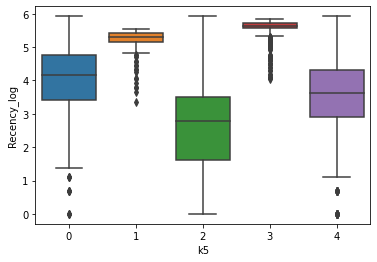

In [79]:
sns.boxplot(x='k5', y ='Recency_log', data = df_RFM)

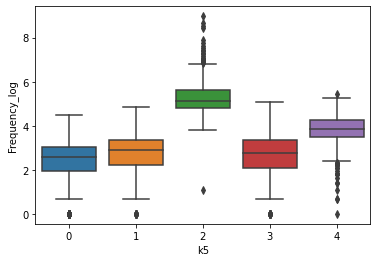

In [80]:
sns.boxplot(x='k5', y ='Frequency_log', data = df_RFM)

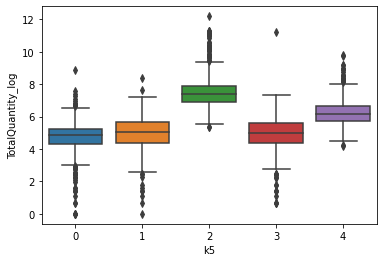

In [81]:
sns.boxplot(x='k5', y ='TotalQuantity_log', data = df_RFM)

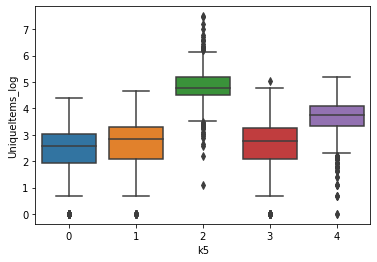

In [82]:
sns.boxplot(x='k5',y ='UniqueItems_log', data = df_RFM)

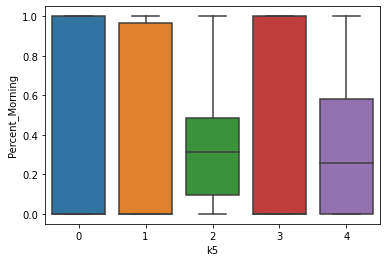

In [83]:
sns.boxplot(x='k5', y ='Percent_Morning', data = df_RFM)

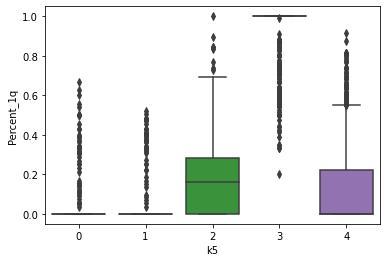

In [85]:
sns.boxplot(x='k5', y ='Percent_1q', data = df_RFM)

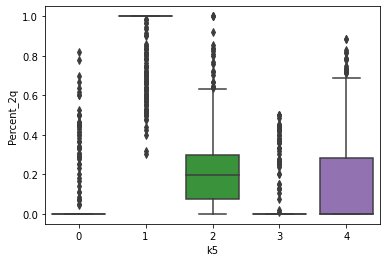

In [86]:
sns.boxplot(x='k5', y ='Percent_2q', data = df_RFM)

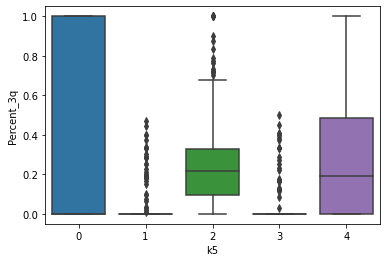

In [87]:
sns.boxplot(x='k5', y ='Percent_3q', data = df_RFM)

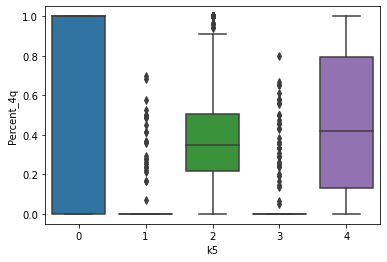

In [88]:
sns.boxplot(x='k5', y ='Percent_4q', data = df_RFM)

In [89]:
sns.scatterplot(x='k5', y ='Percent_Morning', data = df_RFM)

KeyError: 'k5'

In [81]:
def inverse_transform_centroid(df, kmeans, pca, scaler):
    centers = k.means.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns = df.columns)
    return centers

In [82]:
pd.set_option('display.max_columns', 500)

profile_centroid = inverse_tranform_Centroid(df, kmeans, pca, scaler)
profile_Centroid


NameError: name 'inverse_tranform_Centroid' is not defined

### Supplementing with Market Basket Analysis

1. Run this code to generate an encoded item listing:

In [ ]:
new_df = df

In [ ]:
items = list(new_df.Description.unique())
grouped = new_df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

2. What can you say about the `transaction_df` DataFrame?
3. Transpose the DataFrame and get only the 20 most products bought on 100 first transactions.
4. Implement the Apriori and FP Growth Algorithms.
5. Write down your observations.

In [ ]:
#2 What can you say about the transaction_df DataFrame?


In [ ]:
# 3
transaction_df_T = transaction_df.T
transaction_df_T['sum'] = transaction_df_T.sum(axis=1)
transaction_df_T = transaction_df_T.sort_values(by=['sum'], ascending=False)
transaction_df_T_20 = transaction_df_T[:20]
transaction_df_T_20 = transaction_df_T_20.drop(['sum'], axis=1)
trans = transaction_df_T_20.T
trans = trans[:100]

In [ ]:
# 4
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets_ap = apriori(trans, min_support=0.01, use_colnames=True)
frequent_itemsets_fp = fpgrowth(trans, min_support=0.01, use_colnames=True)

In [ ]:
from mlxtend.frequent_patterns import association_rules
rules_ap = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.8)
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.8)

In [ ]:
rules_ap

In [ ]:
rules_fp